# 04 Robustnes Analysis

This notebook includes the code for the robustness analysis. Parameters such as method, situation, dictionary, etc. might need to be specified specifically to replicate all graphs and results from the thesis.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import numpy as np

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=SMALL_SIZE)   
plt.rc('xtick', labelsize=SMALL_SIZE)  
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)   
plt.rc('figure', titlesize=BIGGER_SIZE)  

In [3]:
# Import company list. 
company_names = pd.read_csv("sp500companynames_clean.csv", sep = ";", index_col = 0)
company_names.dropna(inplace = True)
company_names.rename(columns = {"companyname":"Name"}, inplace = True)
company_names["Name"] = company_names["Name"].str.lower()
companies = company_names["Name"]

# Load and clean list of english nouns and generate random sample.
nouns = pd.read_csv('nouns.csv', sep=";")
nouns = nouns[nouns['nouns'].str.strip().str.split(' ').str.len().eq(1)] # Only considering single word nouns.
nouns_sample = nouns["nouns"].sample(n = 800, random_state = 42)
nouns_sample = list(nouns_sample)

# Load action verbs.
action_verbs = pd.read_csv("action_verbs_final.csv", sep = ";", index_col = 0)

# Import and prepare dictionaries. 
dictionaries = pd.read_csv("dimensions_matched_manual.csv", sep = ";", index_col = 0)
dictionaries = dictionaries[dictionaries.Dictionary != "Politics"].reset_index()
dictionaries["tuple"] = list(zip(dictionaries["Term2"].astype(str), dictionaries["Term1"].astype(str)))
dictionaries = dictionaries[["Dictionary", "tuple"]]
dictionaries["tuple"] = dictionaries["tuple"].astype(str)
unique_dictionaries = dictionaries.drop_duplicates(subset='tuple', keep="last")
unique_dictionaries.reset_index(inplace = True)

# Define context list. 
context_list = ["works", "worked", "will work", "has worked", "is working","is employed", "was employed", "will be employed", "has been employed"]

## 1. Robustness between Tenses & Synonyms (Dimension Level)

In [4]:
# Robustness of tenses and synonyms 

context_robustness_firms = pd.DataFrame()
context_robustness_firms["tuple"] = dictionaries["tuple"].unique()

for context in tqdm(context_list):
    result = pd.DataFrame()
    for company in companies:
        file = pd.read_csv(f"./01_Embeddings/Embedd_Firms/Work_context/{company}_{context}.csv")
        file = file["female-male"]
        result = pd.concat([result, file], axis=1, join="outer")
        
    result = pd.DataFrame(result.loc[:, result.columns.str.startswith('female-male')].mean(axis=1).round(7), columns = ["female-male"])
    
    result["tuple"] = dictionaries["tuple"]
    result = result.groupby("tuple").mean().reset_index()
    context_robustness_firms[context] = result["female-male"]
    
firms_corr = context_robustness_firms.drop("tuple", axis = 1).corr()

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# Robustness of tenses and synonyms 

context_robustness_pronouns = pd.DataFrame()
context_robustness_pronouns["tuple"] = dictionaries["tuple"].unique()

for context in tqdm(context_list):
    result = pd.DataFrame()
    for company in companies:
        file = pd.read_csv(f"./01_Embeddings/Embedd_Pronouns/Work_context/{company}_{context}.csv")
        file = file["female-male"]
        result = pd.concat([result, file], axis=1, join="outer")
        
    result = pd.DataFrame(result.loc[:, result.columns.str.startswith('female-male')].mean(axis=1).round(7), columns = ["female-male"])
    
    result["tuple"] = dictionaries["tuple"]
    result = result.groupby("tuple").mean().reset_index()
    context_robustness_pronouns[context] = result["female-male"]
    
pronouns_corr = context_robustness_pronouns.drop("tuple", axis = 1).corr()

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
matrix_firms = np.triu(firms_corr)
matrix_pronouns = np.triu(pronouns_corr)

<AxesSubplot: title={'center': 'Embedding Correlation for Embedding Firms'}>

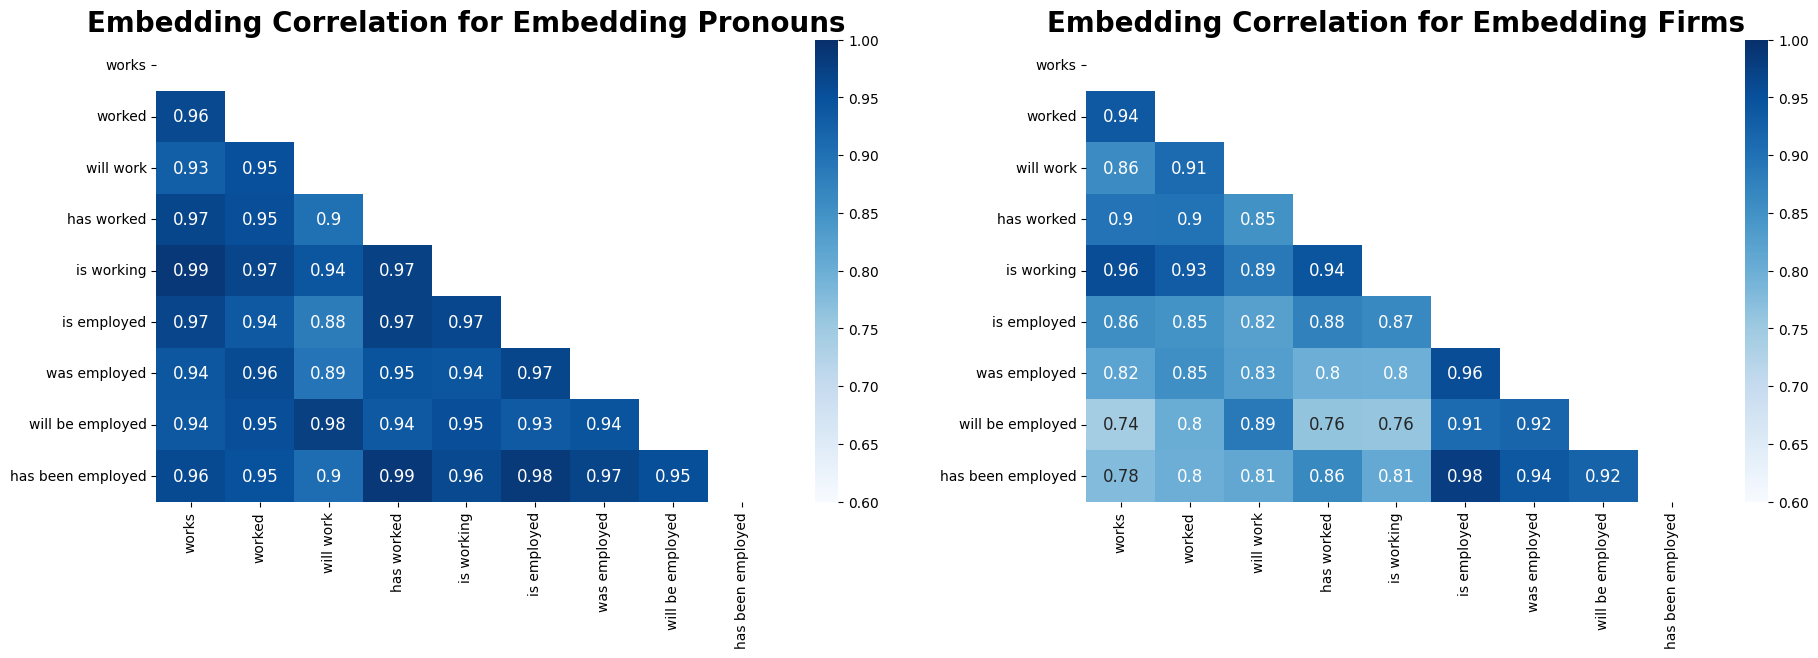

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols=2, figsize=(22, 6))

ax1.set_title("Embedding Correlation for Embedding Pronouns", weight = "bold", size = 20)
sns.heatmap(pronouns_corr, annot = True, mask = matrix_pronouns, cmap = "Blues", ax = ax1, vmin=0.6, vmax=1)

ax2.set_title("Embedding Correlation for Embedding Firms", weight = "bold", size = 20)
sns.heatmap(firms_corr, annot = True, mask = matrix_firms, cmap = "Blues", ax = ax2, vmin=0.6, vmax=1)

#fig.savefig("EmbeddingCorrelation.pdf", bbox_inches='tight')

## 1.1 Robustness between Tenses & Synonyms (Firm Level)

In [11]:
def get_situation_zscores(method, dic): 
    
    final_res = pd.DataFrame()

    for s in context_list: 
        res = pd.read_csv(f"./01_Embeddings/{method}/{s}_zscores.csv")
        res.rename(columns = {f"{dic}_Female-Male_zScore":f"{s}"}, inplace = True)
        res = res[f"{s}"]
        final_res = pd.concat([final_res, res], axis=1) 
    
    return final_res.corr()

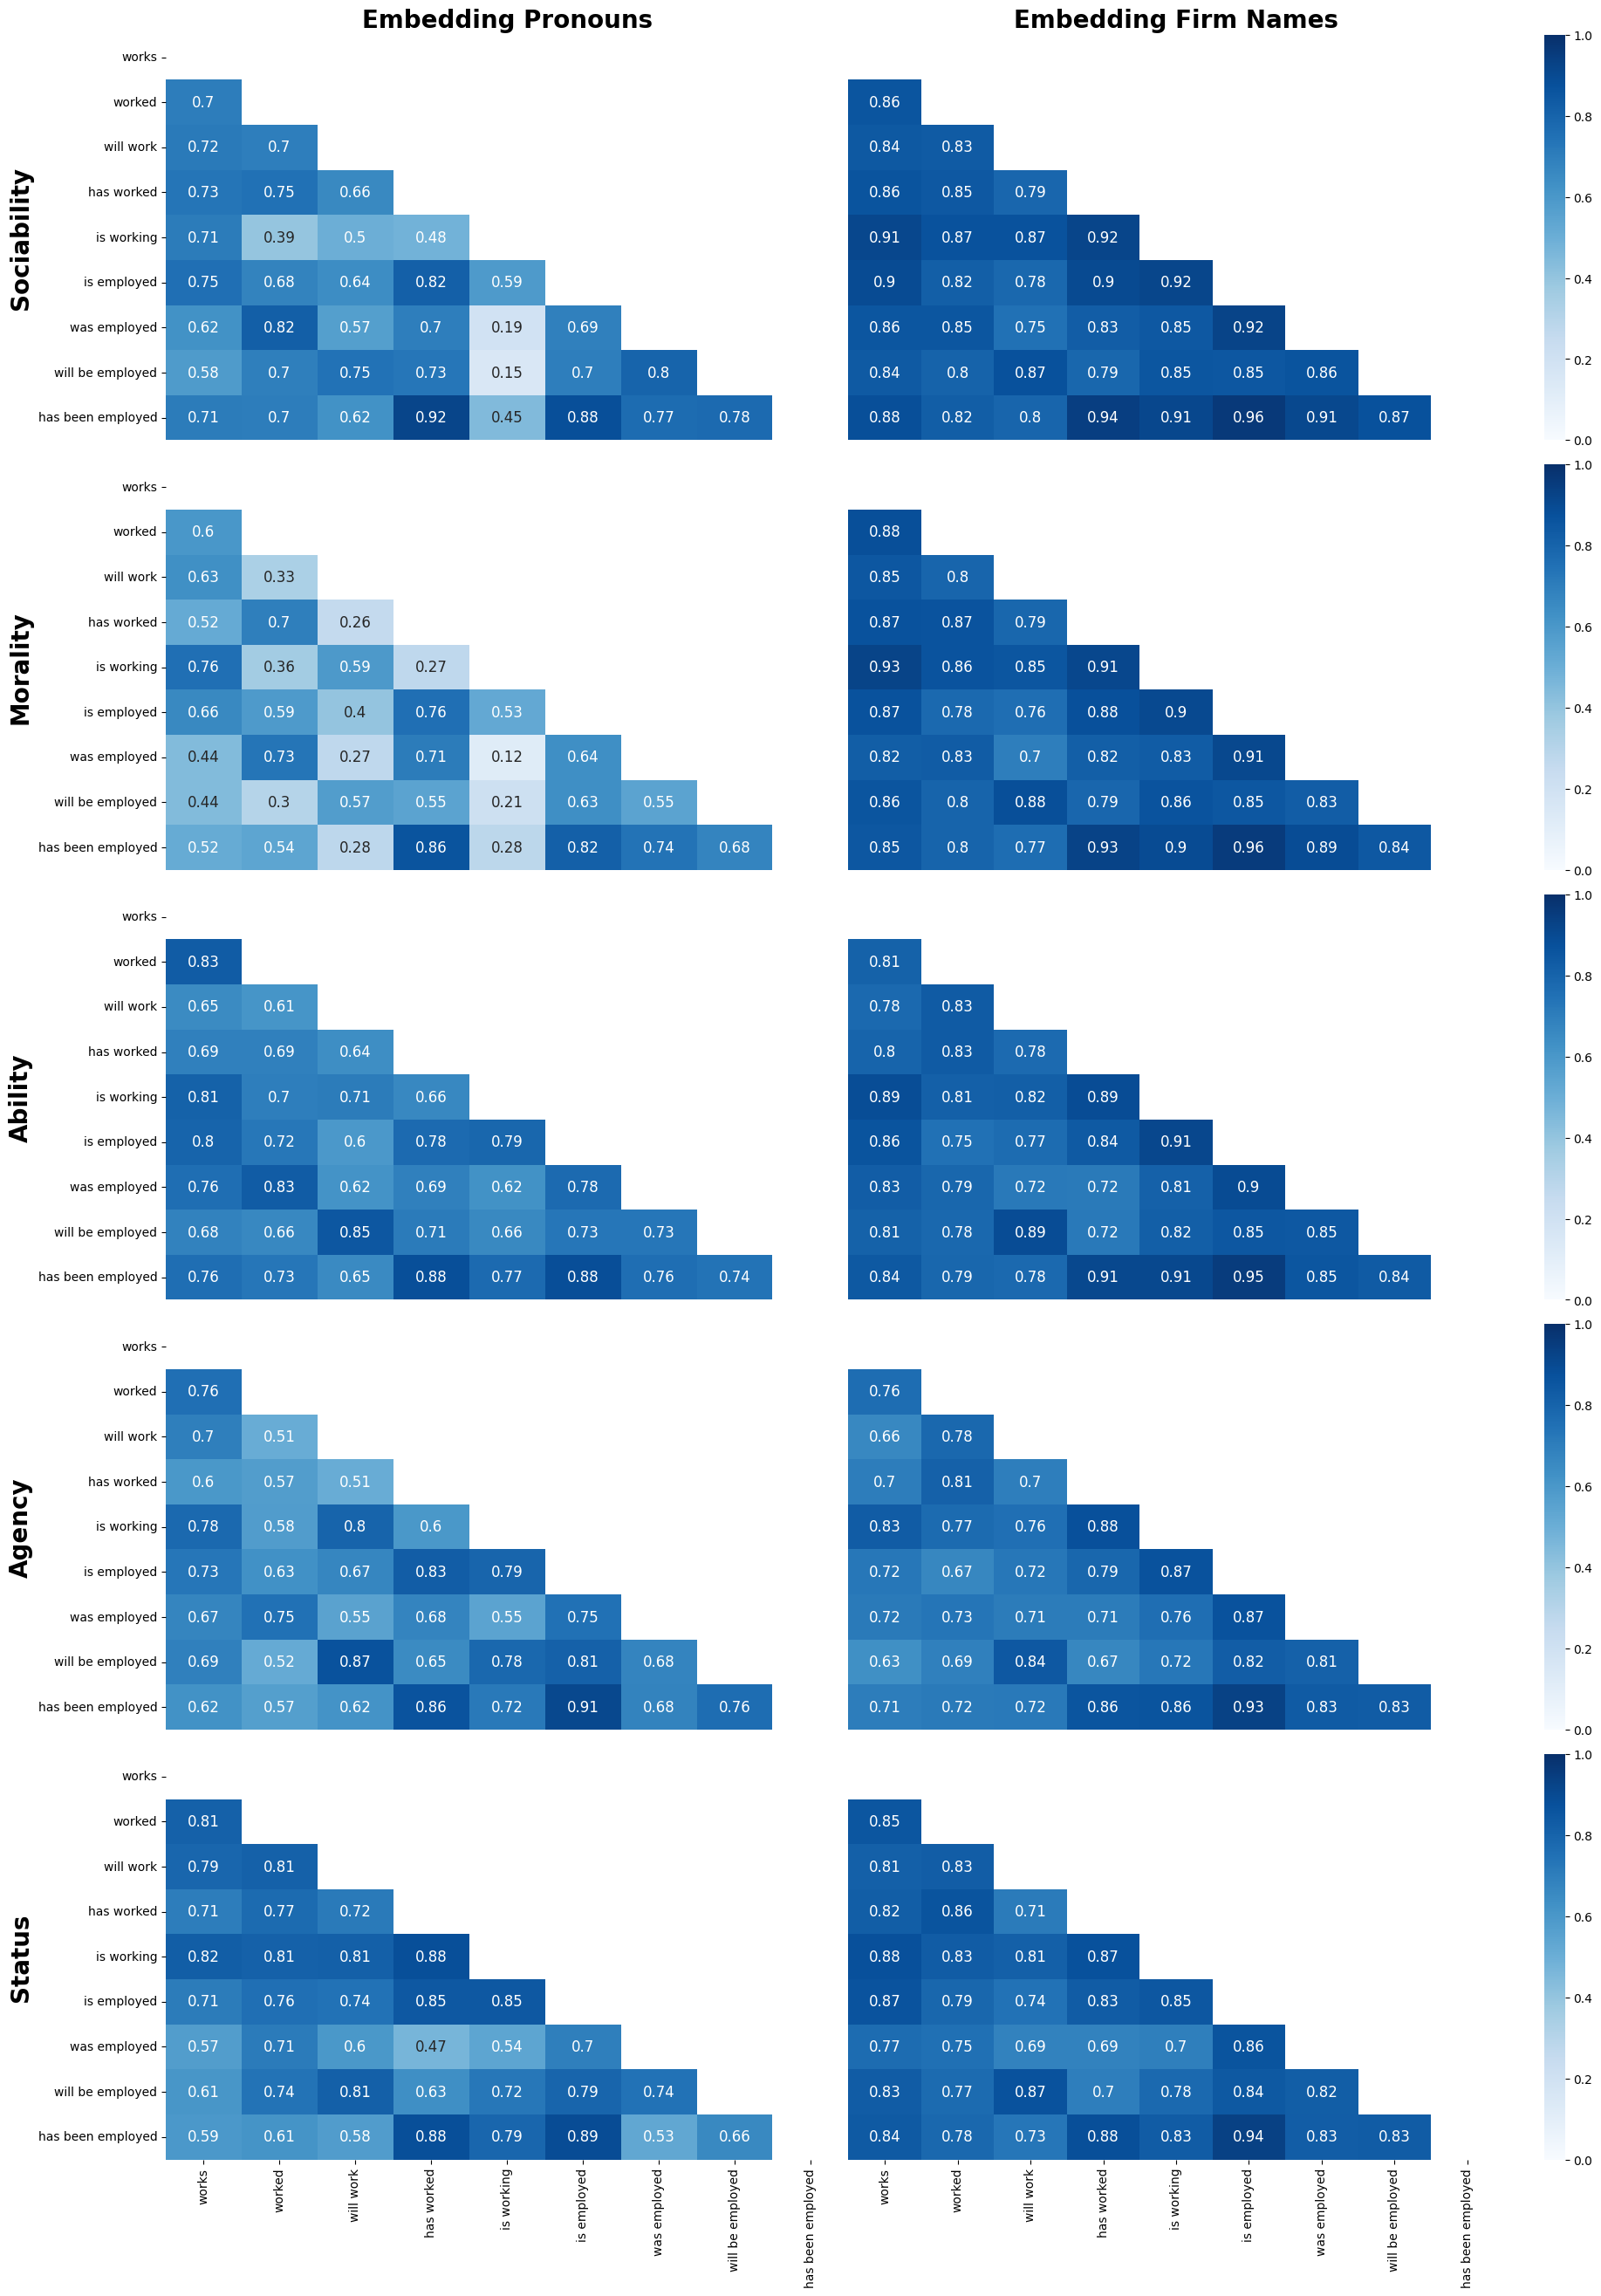

In [12]:
fig, axs = plt.subplots(nrows = 5,ncols=2, figsize=(18, 25), width_ratios=[1, 1.2], constrained_layout = True)
fig.tight_layout()

# Sociability
axs[0,0].set_title("Embedding Pronouns", weight = "bold", size = 20)
axs[0,1].set_title("Embedding Firm Names", weight = "bold", size = 20)
pronouns = get_situation_zscores("Embedd_Pronouns/Work_context", "Sociability")
firm = get_situation_zscores("Embedd_Firms/Work_context", "Sociability")
sns.heatmap(pronouns, annot = True, xticklabels=False, yticklabels=True, mask = np.triu(pronouns), cmap = "Blues", ax = axs[0,0], vmin=0, vmax=1, cbar = False)
axs[0,0].set_ylabel("Sociability", weight = "bold", size = 20)
sns.heatmap(firm, annot = True, xticklabels=False, yticklabels=False, mask = np.triu(firm), cmap = "Blues", ax = axs[0,1], vmin=0, vmax=1)

# Morality
pronouns = get_situation_zscores("Embedd_Pronouns/Work_context", "Morality")
firm = get_situation_zscores("Embedd_Firms/Work_context", "Morality")
sns.heatmap(pronouns, annot = True, xticklabels=False, yticklabels=True, mask = np.triu(pronouns), cmap = "Blues", ax = axs[1,0], vmin=0, vmax=1, cbar = False)
axs[1,0].set_ylabel("Morality", weight = "bold", size = 20)
sns.heatmap(firm, annot = True, xticklabels=False, yticklabels=False, mask = np.triu(firm), cmap = "Blues", ax = axs[1,1], vmin=0, vmax=1)

# Ability
pronouns = get_situation_zscores("Embedd_Pronouns/Work_context", "Ability")
firm = get_situation_zscores("Embedd_Firms/Work_context", "Ability")
sns.heatmap(pronouns, annot = True, xticklabels=False, yticklabels=True,mask = np.triu(pronouns), cmap = "Blues", ax = axs[2,0], vmin=0, vmax=1, cbar = False)
axs[2,0].set_ylabel("Ability", weight = "bold", size = 20)
sns.heatmap(firm, annot = True, xticklabels=False, yticklabels=False, mask = np.triu(firm), cmap = "Blues", ax = axs[2,1], vmin=0, vmax=1)

# Agency
pronouns = get_situation_zscores("Embedd_Pronouns/Work_context", "Agency")
firm = get_situation_zscores("Embedd_Firms/Work_context", "Agency")
sns.heatmap(pronouns, annot = True, xticklabels=False, yticklabels=True, mask = np.triu(pronouns), cmap = "Blues", ax = axs[3,0], vmin=0, vmax=1, cbar = False)
axs[3,0].set_ylabel("Agency", weight = "bold", size = 20)
sns.heatmap(firm, annot = True, xticklabels=False, yticklabels=False, mask = np.triu(firm), cmap = "Blues", ax = axs[3,1], vmin=0, vmax=1)

# Status 
pronouns = get_situation_zscores("Embedd_Pronouns/Work_context", "Status")
firm = get_situation_zscores("Embedd_Firms/Work_context", "Status")
sns.heatmap(pronouns, annot = True, mask = np.triu(pronouns), cmap = "Blues", ax = axs[4,0], vmin=0, vmax=1, cbar = False)
axs[4,0].set_ylabel("Status", weight = "bold", size = 20)
sns.heatmap(firm, annot = True, xticklabels=True, yticklabels=False, mask = np.triu(firm), cmap = "Blues", ax = axs[4,1], vmin=0, vmax=1)

# This should have been a loop -.-

plt.subplots_adjust(hspace=0.06, wspace = 0)
#fig.savefig("zscorecorrelation.pdf", bbox_inches='tight')

## 2. Robustness between Situations

In [13]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

In [14]:
s = ['Creative','Helping','Leadership','Organizational','Quantitative','Research','Teaching','Technical']

In [15]:
def get_situation_correlation(method): 
    
    work = pd.read_csv(f"./01_Embeddings/{method}/Work_context/zscores.csv", index_col = 0)
    work.drop("Permco", axis = 1, inplace = True)
    communication = pd.read_csv(f"./01_Embeddings/{method}/Communication_context/zscores.csv", index_col = 0)
    communication.drop(["Permco", "Company"], axis = 1, inplace = True)
    result = pd.DataFrame(work.corrwith(communication))
    result.rename(columns = {0:"Communication"}, inplace = True)

    for situation in s: 

        df = pd.read_csv(f"./01_Embeddings/{method}/{situation}_context/zscores.csv", index_col = 0)
        df.drop(["Permco", "Company"], axis = 1, inplace = True)
        df = pd.DataFrame(work.corrwith(df))
        df.rename(columns = {0:situation}, inplace = True)
        result = pd.concat([result, df], axis=1, join="outer")

    result = result.reset_index()
    result["index"] = result["index"].str.split("_").str.get(0)
    result.rename(columns = {"index":"Dictionary"}, inplace = True)
    result.set_index("Dictionary", inplace = True)
    
    return result

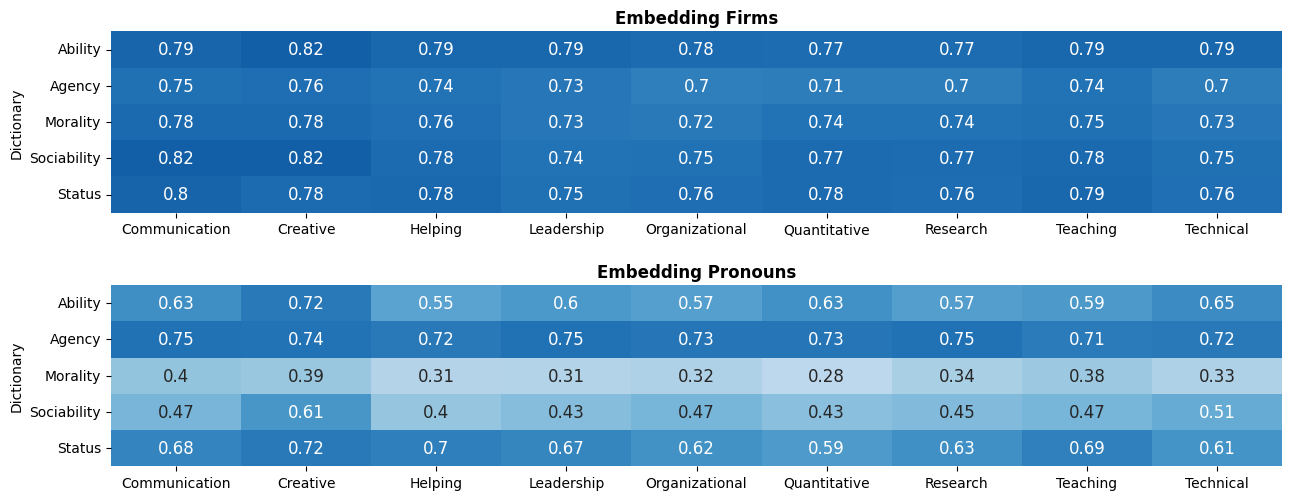

In [16]:
firm_res = get_situation_correlation("Embedd_Firms")
pronoun_res = get_situation_correlation("Embedd_Pronouns")

fig, (ax1, ax2) = plt.subplots(nrows = 2,ncols=1, figsize=(12.5, 5))
fig.tight_layout()

sns.heatmap(firm_res, annot = True,  cmap="Blues", ax = ax1, cbar = False, vmin=0, vmax=1)
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
ax1.set_title("Embedding Firms", size = 12, weight = "bold")

sns.heatmap(pronoun_res, annot = True,  cmap="Blues", ax = ax2, cbar = False, vmin=0, vmax=1)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=0)
ax2.set_title("Embedding Pronouns", size = 12, weight = "bold")

plt.subplots_adjust(hspace=0.4, wspace = 0)

#fig.savefig("situation_correlation.pdf", bbox_inches='tight')

## 3. Robustness between Methods

In [17]:
# Read firm embedding results. 

result_firms = pd.DataFrame()
for company in tqdm(companies):
    file = pd.read_csv(f"./01_Embeddings/Embedd_Firms/Work_context/{company}_context_average.csv")
    file = file["average_female-male"]
    result_firms = pd.concat([result_firms, file], axis=1, join="outer")

result_firms = pd.DataFrame(result_firms.loc[:, result_firms.columns.str.startswith('average_female-male')].mean(axis=1).round(7), columns = ["female-male"])
result_firms["tuple"] = dictionaries["tuple"]

  0%|          | 0/782 [00:00<?, ?it/s]

In [18]:
# Read firm embedding results for real names. 

result_firms_names = pd.DataFrame()
for company in tqdm(companies):
    file = pd.read_csv(f"./01_Embeddings/Embedd_Firms/Work_Names_context/{company}_context_average.csv")
    file = file["average_female-male"]
    result_firms_names = pd.concat([result_firms_names, file], axis=1, join="outer")

result_firms_names = pd.DataFrame(result_firms_names.loc[:, result_firms_names.columns.str.startswith('average_female-male')].mean(axis=1).round(7), columns = ["female-male"])
result_firms_names["tuple"] = dictionaries["tuple"]

  0%|          | 0/782 [00:00<?, ?it/s]

In [19]:
# Read pronoun embedding results. 

result_pronouns = pd.DataFrame()
for company in tqdm(companies):
    file = pd.read_csv(f"./01_Embeddings/Embedd_Pronouns/Work_context/{company}_context_average.csv")
    file = file["average_female-male"]
    result_pronouns = pd.concat([result_pronouns, file], axis=1, join="outer")

result_pronouns = pd.DataFrame(result_pronouns.loc[:, result_pronouns.columns.str.startswith('average_female-male')].mean(axis=1).round(7), columns = ["female-male"])
result_pronouns["tuple"] = dictionaries["tuple"]

  0%|          | 0/782 [00:00<?, ?it/s]

In [20]:
# Read pronoun embedding results for real names. 

result_pronouns_names = pd.DataFrame()
for company in tqdm(companies):
    file = pd.read_csv(f"./01_Embeddings/Embedd_Pronouns/Work_Names_context/{company}_context_average.csv")
    file = file["average_female-male"]
    result_pronouns_names = pd.concat([result_pronouns_names, file], axis=1, join="outer")

result_pronouns_names = pd.DataFrame(result_pronouns_names.loc[:, result_pronouns_names.columns.str.startswith('average_female-male')].mean(axis=1).round(7), columns = ["female-male"])
result_pronouns_names["tuple"] = dictionaries["tuple"]

  0%|          | 0/782 [00:00<?, ?it/s]

In [21]:
# Correlation between average dimension bias of firms and pronouns 
result_pronouns.corrwith(result_firms)

female-male    0.044469
dtype: float64

In [22]:
# Correlation between average dimension bias of firm names and firm pronouns 
result_firms.corrwith(result_firms_names)

female-male   -0.023565
dtype: float64

In [23]:
# Correlation between average dimension bias of names and pronouns 
result_pronouns.corrwith(result_pronouns_names)

female-male    0.618674
dtype: float64

In [24]:
res_pronouns = pd.read_csv("01_Embeddings/Embedd_Pronouns/Work_context/zscores.csv", index_col = 0)
res_pronouns_names = pd.read_csv("01_Embeddings/Embedd_Pronouns/Work_Names_context/zscores.csv", index_col = 0)

In [25]:
res_firms = pd.read_csv("01_Embeddings/Embedd_Firms/Work_context/zscores.csv", index_col = 0)
res_firms_names = pd.read_csv("01_Embeddings/Embedd_Firms/Work_Names_context/zscores.csv", index_col = 0)

In [34]:
# Pronouns with names 
res_pronouns.corrwith(res_pronouns_names)

# Pronouns with firms 
res_pronouns.corrwith(res_firms)

# Firms with Firm Names 
res_firms.corrwith(res_firms_names)

Permco                            1.000000
Ability_Female-Male_zScore        0.178061
Agency_Female-Male_zScore         0.071466
Morality_Female-Male_zScore       0.091712
Sociability_Female-Male_zScore    0.078500
Status_Female-Male_zScore         0.096637
dtype: float64

## 4. Dictionary Consistency

In [35]:
method = "01_Embeddings/Embedd_Pronouns/Work_context"

all_firms_pronouns = pd.DataFrame()

for firm in tqdm(company_names["Name"].unique()): 
    res = pd.read_csv(f"./{method}/{firm}_context_average.csv")
    res = res[["tuple", "average_female-male"]].groupby("tuple", sort = False).mean().reset_index()
    res["Dictionary"] = unique_dictionaries["Dictionary"]
    res = res[res["Dictionary"] == "Status"]
    res.drop("Dictionary", axis = 1, inplace = True)
    res.set_index ("tuple", inplace = True)
    res.rename(index = {"tuple":"Dimension"}, inplace = True)
    res = res.transpose()
    res = res.reset_index(drop = True)
    res["Company"] = firm
    all_firms_pronouns = all_firms_pronouns.append(res)

  0%|          | 0/782 [00:00<?, ?it/s]

In [36]:
method = "01_Embeddings/Embedd_Firms/Work_context"

all_firms_firms = pd.DataFrame()

for firm in tqdm(company_names["Name"].unique()): 
    res = pd.read_csv(f"./{method}/{firm}_context_average.csv")
    res = res[["tuple", "average_female-male"]].groupby("tuple", sort = False).mean().reset_index()
    res["Dictionary"] = unique_dictionaries["Dictionary"]
    res = res[res["Dictionary"] == "Status"]
    res.drop("Dictionary", axis = 1, inplace = True)
    res.set_index ("tuple", inplace = True)
    res = res.transpose()
    res = res.reset_index(drop = True)
    res["Company"] = firm
    all_firms_firms = all_firms_firms.append(res)

  0%|          | 0/782 [00:00<?, ?it/s]

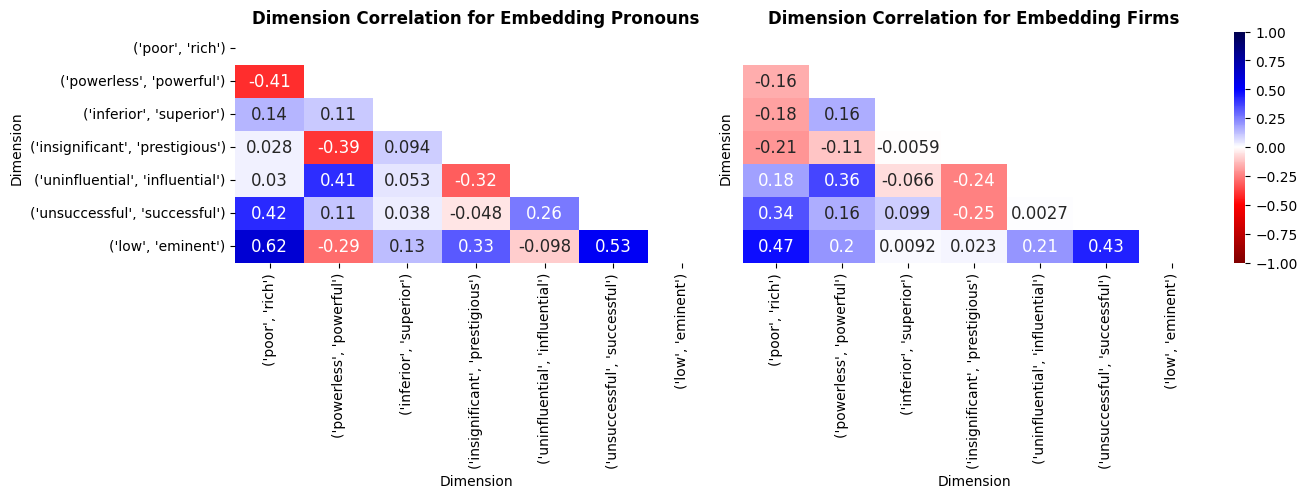

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols=2, figsize=(14, 3),width_ratios=[1, 1.2])

corr_pronouns = all_firms_pronouns.drop("Company", axis = 1).corr()
matrix_pronouns = np.triu(corr_pronouns)

ax1.set_title("Dimension Correlation for Embedding Pronouns", weight = "bold", size = 12)
sns.heatmap(corr_pronouns, annot = True, mask = matrix_pronouns, cmap="seismic_r", ax = ax1, vmin = -1, vmax = 1, cbar = False)
ax1.set_ylabel("Dimension")
ax1.set_xlabel("Dimension")
corr_firms = all_firms_firms.drop("Company", axis = 1).corr()
matrix_firms = np.triu(corr_firms)

ax2.set_title("Dimension Correlation for Embedding Firms", weight = "bold", size = 12)
sns.heatmap(corr_firms, annot = True, mask = matrix_firms, cmap="seismic_r", ax = ax2,vmin = -1, vmax = 1, yticklabels=False)
ax2.set_ylabel("Dimension")
ax2.set_xlabel("Dimension")

fig.savefig("EmbeddingCorrelation.pdf", bbox_inches='tight')
plt.subplots_adjust(wspace = 0.05)
#fig.savefig("dimension_correlation.pdf", bbox_inches='tight')

In [38]:
# Function obtained from: https://towardsdatascience.com/cronbachs-alpha-theory-and-application-in-python-d2915dd63586

def cronbach_alpha(df):    
    df_corr = df.corr()
    N = df.shape[1]
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

In [39]:
def get_cronbach_alpha(method):

    situations = ["Work", "Communication", 'Creative','Helping','Leadership','Organizational','Quantitative',
                  'Research','Teaching','Technical']

    cronbach_alpha_results = pd.DataFrame(columns = ["Cronbach's Alpha", "Dictionary", "Situation"])

    for s in tqdm(situations): 

        for dictionary in dictionaries["Dictionary"].unique(): 

            all_firms = pd.DataFrame()

            for firm in company_names["Name"].unique(): 
                res = pd.read_csv(f"./01_Embeddings/{method}/{s}_context/{firm}_context_average.csv")
                res = res[["tuple", "average_female-male"]].groupby("tuple", sort = False).mean().reset_index()
                res["Dictionary"] = unique_dictionaries["Dictionary"]
                res = res[res["Dictionary"] == dictionary]
                res.drop("Dictionary", axis = 1, inplace = True)
                res.set_index ("tuple", inplace = True)
                res = res.transpose()
                res = res.reset_index(drop = True)
                res["Company"] = firm
                all_firms = all_firms.append(res)

            all_firms = all_firms.reset_index(drop = True)
            all_firms.iloc[:, :-1] = all_firms.iloc[:, :-1].rank()

            alpha = cronbach_alpha(all_firms.iloc[:, :-1])
            
            cronbach_alpha_results.loc[len(cronbach_alpha_results)] = [alpha, dictionary, s]
            
    return cronbach_alpha_results

In [40]:
alpha_firms = get_cronbach_alpha("Embedd_Firms")
alpha_pronouns = get_cronbach_alpha("Embedd_Pronouns")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

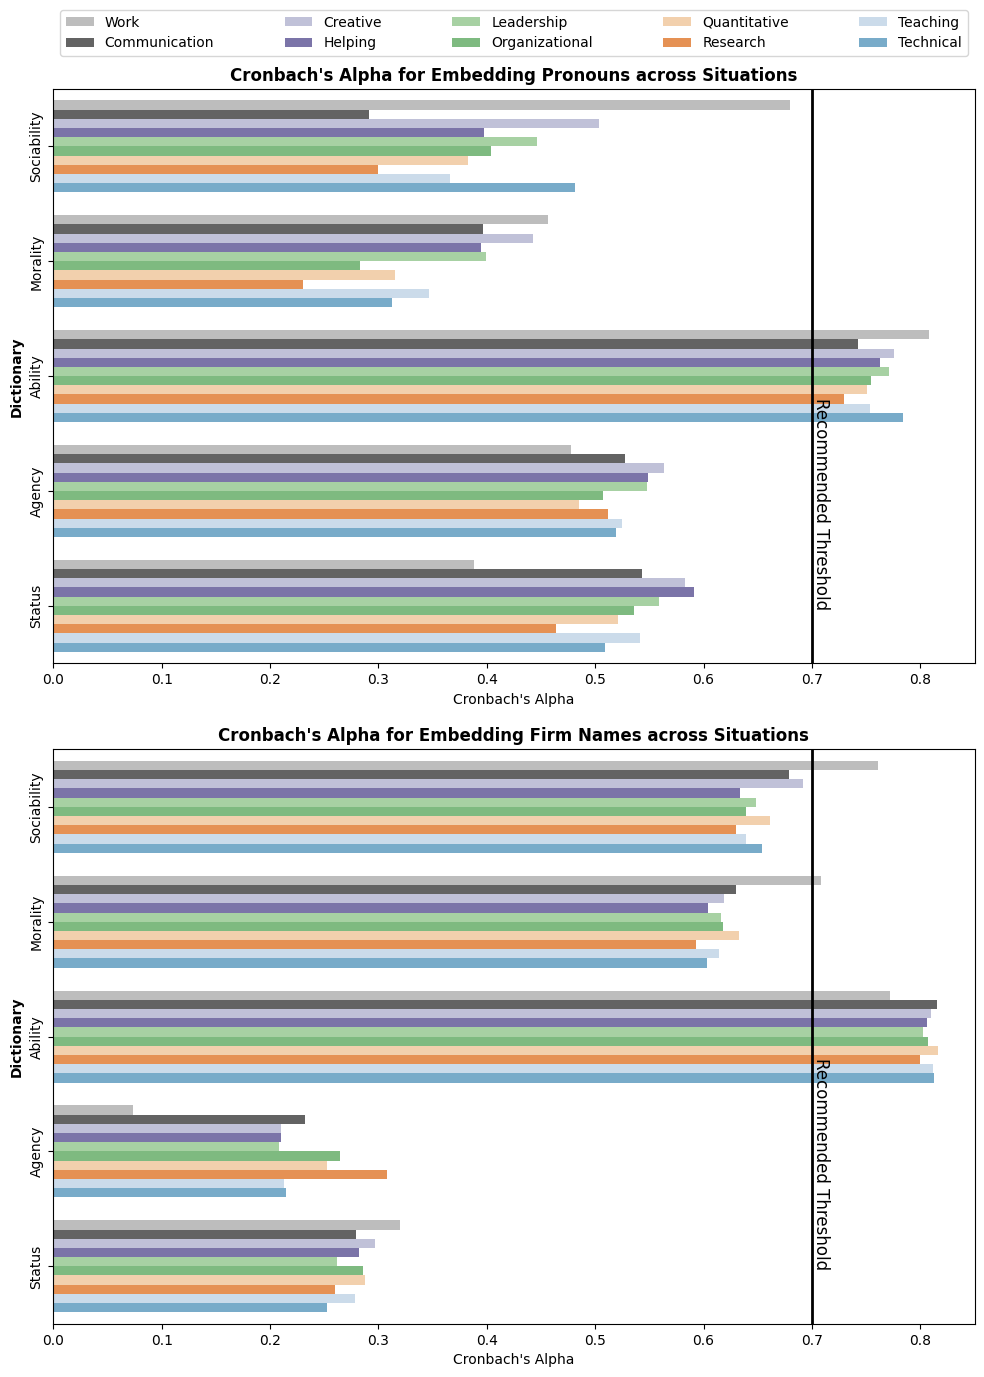

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows = 2,ncols=1, figsize=(10, 13))
fig.tight_layout()

ax1.set_title("Cronbach's Alpha for Embedding Pronouns across Situations", size = 12, weight = "bold")
sns.barplot(data=alpha_pronouns, y = "Dictionary", x = "Cronbach's Alpha", hue = "Situation", orient = 'h', ax = ax1, palette = "tab20c_r")
ax1.legend(bbox_to_anchor=(0, 1.1, 1, 0.05), loc='upper left', mode = "expand", ncol = 5)
ax1.set_yticks(ax1.get_yticks(), ax1.get_yticklabels(), rotation=90, va='center')
ax1.axvline(0.7, color = "black", linewidth= 2, label = "Recommended Level")
ax1.set_xlim(0,0.85)
ax1.set_ylabel("Dictionary", weight = "bold")
ax1.text(0.7, 4, "Recommended Threshold", rotation = 270)

ax2.set_title("Cronbach's Alpha for Embedding Firm Names across Situations", size = 12, weight = "bold")
sns.barplot(data=alpha_firms, y = "Dictionary", x = "Cronbach's Alpha", hue = "Situation", orient = 'h', palette = "tab20c_r", ax = ax2)
ax2.set_yticks(ax2.get_yticks(), ax2.get_yticklabels(), rotation=90, va='center')

ax2.get_legend().remove()
ax2.axvline(0.7, color = "black", linewidth= 2)
ax2.set_xlim(0,0.85)
ax2.set_ylabel("Dictionary", weight = "bold")
ax2.text(0.7, 4, "Recommended Threshold", rotation = 270)

plt.subplots_adjust(hspace=0.15, wspace = 0)

#fig.savefig("cronbach.pdf", bbox_inches='tight')